## 0. Redefine the imports, paths, files and variables

In [1]:
import os
import easyocr
import cv2 
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

ROOT_PATH = r"C:\Users\nike.olabiyi\AI-repository\NumberPlateModel"
BASE_PATH = os.path.join('Tensorflow', 'workspace')

CUSTOM_MODEL_NAME = 'numberPlate_recogntinion' 
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'ANNOTATION_PATH': os.path.join(BASE_PATH, 'annotations'),
    'IMAGE_PATH': os.path.join(ROOT_PATH,'DemoPictures'),
    'CHECKPOINT_PATH': os.path.join(BASE_PATH, 'tensorflow_models', CUSTOM_MODEL_NAME),
}

print(paths)

files = {
    'PIPELINE_CONFIG':os.path.join(paths['CHECKPOINT_PATH'], 'pipeline.config'),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

# Thresholds
confidence_threshold = 0.7 # the confidence score for a detected license plate 
plate_threshold = 0.15  # defines the part of the licence plate (%) to be considered to be state/region/county & number

{'ANNOTATION_PATH': 'Tensorflow\\workspace\\annotations', 'IMAGE_PATH': 'C:\\Users\\nike.olabiyi\\AI-repository\\NumberPlateModel\\DemoPictures', 'CHECKPOINT_PATH': 'Tensorflow\\workspace\\tensorflow_models\\numberPlate_recogntinion'}


## 1. Load the model from the checkpoint

In [2]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Run dummy input to initialize variables
dummy_image = tf.zeros((1, 640, 640, 3), dtype=tf.float32)
_ = detection_model.preprocess(dummy_image)  # Force variable creation

# Restore checkpoint
ckpt = tf.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.abspath(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11'))).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

## 2. Process a car image and detect a number plate (SSD model):

In [3]:
def process_car_image(car_image_name):
    CURR_IMAGE = os.path.join(paths['IMAGE_PATH'], car_image_name)
    # check if image exists
    os.chdir(ROOT_PATH)
    print(os.getcwd()) 
    img = cv2.imread(CURR_IMAGE)

    # Check if image was loaded successfully
    if img is None:
        raise ValueError(f"Failed to load image from {CURR_IMAGE}. Check the file path!")
        
    # proceed to process the image
    image_np = np.array(img)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    
    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    #label_id_offset = 1
    image_np_with_detections = image_np.copy()
    
    image = image_np_with_detections
    return image, detections

## 3. ROI filtering and OCR

In [4]:
def filter_out_plate(plate_crop , ocr_result, plate_threshold):
    rectangle_size = plate_crop.shape[0]*plate_crop.shape[1]
    plate = []

    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))

        if length*height / rectangle_size > plate_threshold:
            plate.append(result[1])
    return plate

In [5]:
def print_number_plate(image_name, confidence_threshold, plate_threshold):
    
    #Process a car image and detect a number plate
    processed_image, detections = process_car_image(image_name)
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> confidence_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    
    # Full image dimensions
    width = processed_image.shape[1]
    height = processed_image.shape[0]

    ocr_result = []  # Initialize before the loop
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        plate_crop  = processed_image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(plate_crop)
        
        print("The car plate:", filter_out_plate(plate_crop , ocr_result, plate_threshold))
        
    for result in ocr_result:
        print(result[1])

## 4. Call the function

In [11]:
image_name = 'Demo6.png'
confidence_threshold = 0.6
plate_threshold = 0.20
print_number_plate(image_name, confidence_threshold, plate_threshold)

C:\Users\nike.olabiyi\AI-repository\NumberPlateModel


The car plate: ['KAOzHK6716']
KAOzHK6716


## Test

In [109]:
CURR_IMAGE = os.path.join(paths['IMAGE_PATH'], 'Demo7.png')
print(CURR_IMAGE)
detection_threshold = 0.7

C:\Users\nike.olabiyi\AI-repository\NumberPlateModel\DemoPictures\Demo7.png


In [111]:
os.chdir(ROOT_PATH)
print(os.getcwd()) 
img = cv2.imread(CURR_IMAGE)

# Check if image was loaded successfully
if img is None:
    raise ValueError(f"Failed to load image from {CURR_IMAGE}. Check the file path!")

C:\Users\nike.olabiyi\AI-repository\NumberPlateModel


In [113]:
img = cv2.imread(CURR_IMAGE)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

### Visualize the result

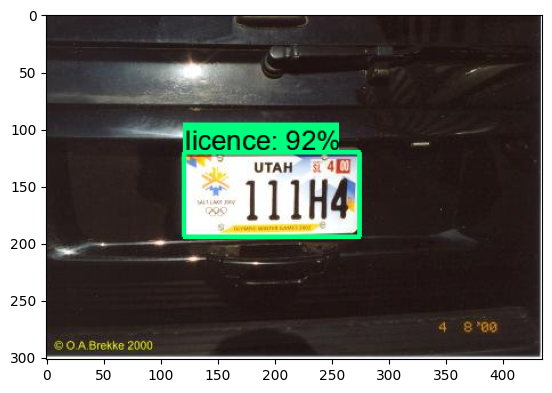

In [115]:
%matplotlib inline
# is a magic command in Jupyter Notebook that tells Matplotlib to display plots directly inside the notebook instead of opening them in a separate window.
# Scores, boxes and classes above threhold
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes']+label_id_offset,
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=5,
    min_score_thresh=.8,
    agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [117]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

width = image.shape[1]
height = image.shape[0]

[0.40116242 0.27654487 0.6438161  0.6322473 ]
[121.15104955 120.29701799 194.43246627 275.02758801]
[([[61, 7], [101, 7], [101, 21], [61, 21]], 'UTAH', 0.9923378229141235), ([[113, 5], [149, 5], [149, 21], [113, 21]], '4 40', 0.16431101969751824), ([[46, 16], [154, 16], [154, 66], [46, 66]], '111h4', 0.6143639275768961)]


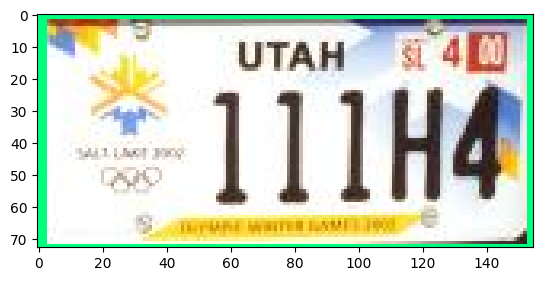

In [119]:
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [121]:
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])

14
UTAH
16
4 40
50
111h4


## OCR Filtering

In [127]:
plate_threshold = 0.2

In [129]:
def filter_text(region, ocr_result, plate_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > plate_threshold:
            plate.append(result[1])
    return plate

In [131]:
filter_text(region, ocr_result, plate_threshold)

['111h4']

In [35]:
def ocr_it(image, detections, detection_threshold, plate_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    region= []
    ocr_result = []
    plate = []
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        print("Plate:", filter_text(region, ocr_result, plate_threshold))
        plate = filter_text(region, ocr_result, plate_threshold)
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        return text, region

Plate: ['PGoMN12']


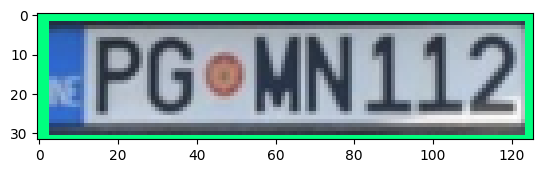

NameError: name 'text' is not defined

In [37]:
detection_threshold = 0.7
plate_threshold = 0.5
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, plate_threshold)